# Introduction

The datasets used in the following analysis are available here: https://www.kaggle.com/c/rossmann-store-sales/overview

Notes:
The datasets provide historical sales data for 1,115 Rossmann stores. 
The task of the original Kaggle challenge is to forecast the "Sales" column for the test set. 
Note that some stores in the dataset were temporarily closed for refurbishment.

Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that * all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Data and packages upload

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [315]:
low_memory=False

#sample_submission = pd.read_csv("sample_submission.csv", sep=',')
store = pd.read_csv("store.csv", sep=',')
test = pd.read_csv("test.csv", sep=',')
train = pd.read_csv("train.csv", sep=',')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [316]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [18]:
sample_submission.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [14]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data cleaning & exploratory analysis

In [317]:
#Let´s start with the train dataset to check how are sales behaving
#check if dat contains na & clean
train.isnull().values.any()
#check how is the store dataset filled:
train.count(0)/train.shape[0] * 100

Store            100.0
DayOfWeek        100.0
Date             100.0
Sales            100.0
Customers        100.0
Open             100.0
Promo            100.0
StateHoliday     100.0
SchoolHoliday    100.0
dtype: float64

> Observations: The train dataset is fully filled

<AxesSubplot:xlabel='Date'>

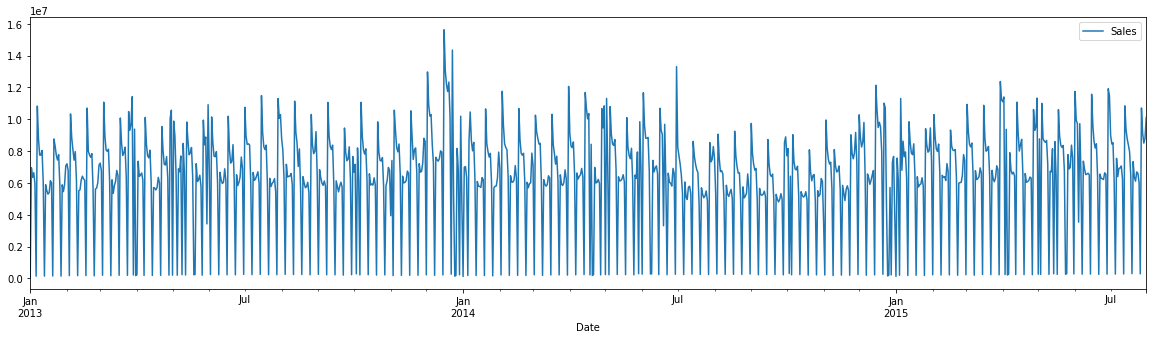

In [318]:
#create development of sales over time
train['Date'] = pd.to_datetime(train['Date'],format = '%Y-%m-%d')
plot_sales = train.groupby(['Date']).agg({'Sales': 'sum'}).round(0)
plot_sales.plot.line(figsize = (20,5))

In [319]:
#check how is the store dataset filled:
store.count(0)/store.shape[0] * 100

Store                        100.000000
StoreType                    100.000000
Assortment                   100.000000
CompetitionDistance           99.730942
CompetitionOpenSinceMonth     68.251121
CompetitionOpenSinceYear      68.251121
Promo2                       100.000000
Promo2SinceWeek               51.210762
Promo2SinceYear               51.210762
PromoInterval                 51.210762
dtype: float64

> Observations: The store dataset is not fully complete.\
Let´s proceed to data completion

In [320]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store.CompetitionOpenSinceYear.fillna(0,inplace=True)
store.Promo2SinceWeek.fillna(0,inplace=True)
store.Promo2SinceYear.fillna(0,inplace=True)
store.PromoInterval.fillna(0,inplace=True)
store.count(0)/store.shape[0] * 100

Store                        100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

In [321]:
#create a merged dataset containing store info and competition infos
train_cplt = train.merge(store, on='Store', how='left')
train_cplt.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.422021e+03,4.926878e+00,1.370173e+03,5.005638e-01,1.164767e+01,1.007011e+03
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.706918e+03,4.283543e+00,9.353634e+02,4.999999e-01,1.532393e+01,1.005877e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.325000e+03,4.000000e+00,2.006000e+03,1.000000e+00,1.000000e+00,2.009000e+03
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03


In [322]:
train_cplt.count(0)/train_cplt.shape[0] * 100


Store                        100.0
DayOfWeek                    100.0
Date                         100.0
Sales                        100.0
Customers                    100.0
Open                         100.0
Promo                        100.0
StateHoliday                 100.0
SchoolHoliday                100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

# get an understanding of the data
In this section we will observe the influence of different features on sales:
- store type
- assortment type
- promotions
- day of the week
- competition distance

## store type influence on sales

In [323]:
train_cplt['SalesperCustomer']=train_cplt['Sales']/train_cplt['Customers']
plot = train_cplt.groupby(['StoreType'],as_index =False).agg({'SalesperCustomer': 'mean'}).round(0)
plot= pd.DataFrame(plot)
plot


,StoreType,SalesperCustomer
0,a,9.0
1,b,5.0
2,c,9.0
3,d,11.0


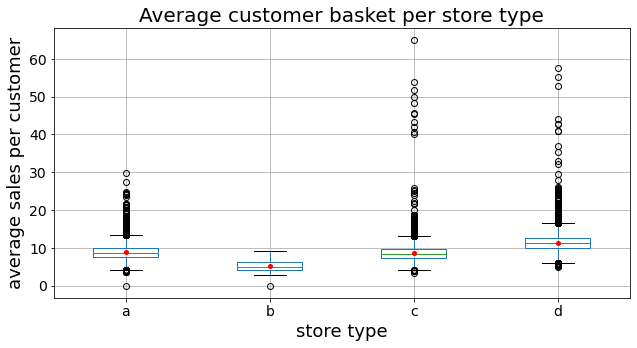

In [324]:
train_cplt.boxplot(column = 'SalesperCustomer', 
                     by='StoreType',
                     showmeans=True,
                     meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"red",
                      "markersize":"4"},
                    figsize=(10,5))
title_boxplot = 'Average customer basket per store type'
plt.title( title_boxplot, fontsize=20)
plt.suptitle('') # that's what you're after
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('store type', fontsize=18)
plt.ylabel('average sales per customer', fontsize=18)
plt.show()

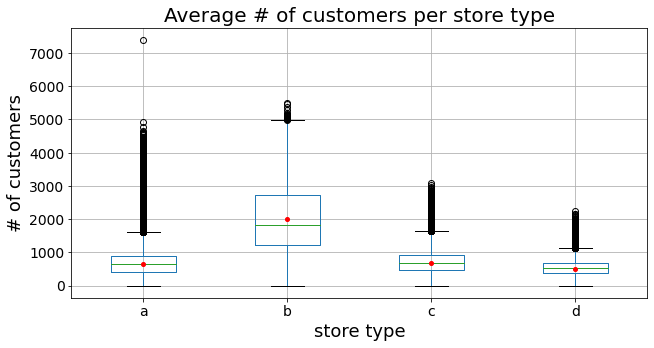

In [325]:
train_cplt.boxplot(column = 'Customers', 
                     by='StoreType',
                     showmeans=True,
                     meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"red",
                      "markersize":"4"},
                    figsize=(10,5))
title_boxplot = 'Average # of customers per store type'
plt.title( title_boxplot, fontsize=20)
plt.suptitle('') # that's what you're after
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('store type', fontsize=18)
plt.ylabel('# of customers', fontsize=18)
plt.show()

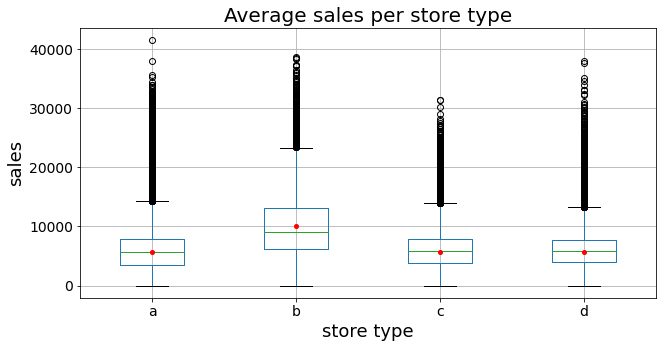

In [326]:
train_cplt.boxplot(column = 'Sales', 
                     by='StoreType',
                     showmeans=True,
                     meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"red",
                      "markersize":"4"},
                    figsize=(10,5))
title_boxplot = 'Average sales per store type'
plt.title( title_boxplot, fontsize=20)
plt.suptitle('') # that's what you're after
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('store type', fontsize=18)
plt.ylabel('sales', fontsize=18)
plt.show()

In [327]:
from scipy import stats
stats.pearsonr(train_cplt.Customers, train_cplt.Sales)[0]

0.8947107732992593

> Observations: number of customers and sales volume have a positive relationship

In [328]:
store.groupby(by=["StoreType","Assortment"]).Assortment.count()

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

## promotion influence on sales

In [329]:
# create Month and Year info
train_cplt['Date'] = pd.to_datetime(train_cplt['Date'],format = '%Y-%m-%d')
train_cplt['Month']=train_cplt.Date.dt.month
train_cplt['Year']=train_cplt.Date.dt.year

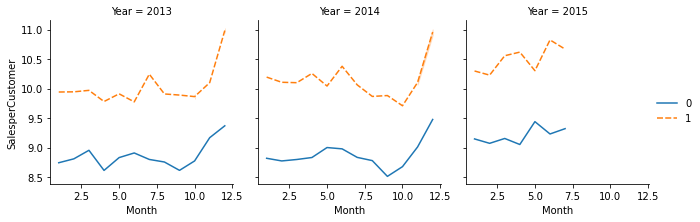

In [330]:
g = sns.FacetGrid(train_cplt, col="Year")
g.map_dataframe(sns.lineplot, x="Month", y="SalesperCustomer", hue="Promo", style="Promo")
g.set_axis_labels("Month", "SalesperCustomer")
g.add_legend()

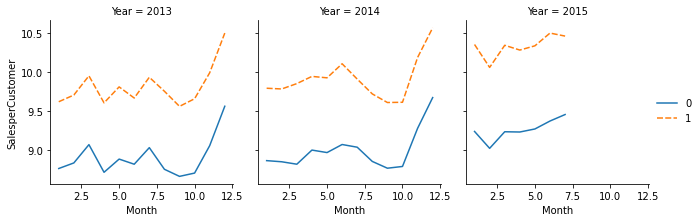

In [331]:
g = sns.FacetGrid(train_cplt, col="Year")
g.map_dataframe(sns.lineplot, x="Month", y="SalesperCustomer", hue="Promo2", style="Promo2")
g.set_axis_labels("Month", "SalesperCustomer")
g.add_legend()

> Observations: from the above graphs we see that the 2 types of promotion have a positive impact on sales per customer

## day influence on sales

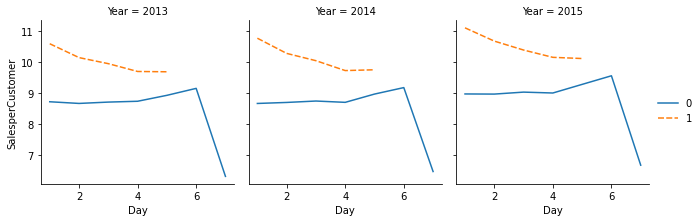

In [332]:
g = sns.FacetGrid(train_cplt, col="Year")
g.map_dataframe(sns.lineplot, x="DayOfWeek", y="SalesperCustomer", hue="Promo", style="Promo")
g.set_axis_labels("Day", "SalesperCustomer")
g.add_legend()

> Observations: The above graphs indicate slightly different sales per customer behavior depending on the day of the week

## competition influence on sales

In [333]:
train_cplt['CompetitionDist_Bucket']=pd.cut(train_cplt['CompetitionDistance'],10, labels=False)
# 0 indicates competition at a short distance and  9 at a long distance

In [334]:
train_cplt.groupby(by="CompetitionDist_Bucket").Sales.mean(),train_cplt.groupby(by="CompetitionDist_Bucket").Customers.mean()

(CompetitionDist_Bucket
 0    5796.261960
 1    5608.340309
 2    5889.022807
 3    5735.477182
 4    5270.847399
 5    5947.780467
 6    4817.702406
 7    6071.001062
 9    7321.466030
 Name: Sales, dtype: float64,
 CompetitionDist_Bucket
 0    660.974486
 1    510.423634
 2    572.670065
 3    586.989276
 4    549.222665
 5    632.484926
 6    488.152159
 7    745.749469
 9    861.176221
 Name: Customers, dtype: float64)

> Observations : the above data indicates that the furthest the competition, the highest the number of customers (and sales)

## final visualisation: correlation matrix

In [335]:
#data transformation to feed the map
train_cplt['StateHoliday'] = train_cplt['StateHoliday'].astype('category')
train_cplt['Assortment'] = train_cplt['Assortment'].astype('category')
train_cplt['StoreType'] = train_cplt['StoreType'].astype('category')
train_cplt['PromoInterval']= train_cplt['PromoInterval'].astype('category')
train_cplt['StateHoliday_cat'] = train_cplt['StateHoliday'].cat.codes
train_cplt['Assortment_cat'] = train_cplt['Assortment'].cat.codes
train_cplt['StoreType_cat'] = train_cplt['StoreType'].cat.codes
train_cplt['PromoInterval_cat'] = train_cplt['PromoInterval'].cat.codes
train_cplt['StateHoliday_cat'] = train_cplt['StateHoliday_cat'].astype('float')
train_cplt['Assortment_cat'] = train_cplt['Assortment_cat'].astype('float')
train_cplt['StoreType_cat'] = train_cplt['StoreType_cat'].astype('float')
train_cplt['PromoInterval_cat'] = train_cplt['PromoInterval_cat'].astype('float')

<AxesSubplot:>

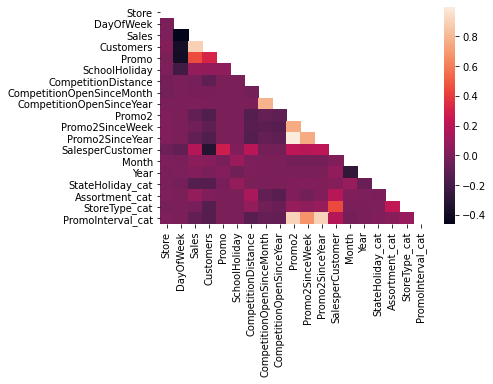

In [336]:
df_correlation=train_cplt[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
        'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'SalesperCustomer', 'Month', 'Year',
       'StateHoliday_cat', 'Assortment_cat', 'StoreType_cat',
       'PromoInterval_cat']]
df_correlation=df_correlation.drop('Open', axis = 1)

upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True #make sure we don't show half of the other triangle
sns.heatmap(df_correlation.corr(),mask=upper_triangle)

# key take aways of the exploratory data analysis

* customers have a strong positive relationship with sales
* promotions have a strong positive relationship with sales
* competition distance has a positive relationship with sales

* storetype has a positive relationship with sales per customer
* assortment has also a positive relationship with sales per customer


# Data transformation and prediction

### prepare the training set

In [337]:
#examine the feature we can use in the model
train_cplt.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'SalesperCustomer', 'Month', 'Year',
       'CompetitionDist_Bucket', 'StateHoliday_cat', 'Assortment_cat',
       'StoreType_cat', 'PromoInterval_cat'],
      dtype='object')

In [338]:
# create a feature for "competition presence since" (in months) as a unique input instead of Month & Year:
train_cplt['CompetitionOpenSince'] = np.where((train_cplt['CompetitionOpenSinceMonth']==0) & (train_cplt['CompetitionOpenSinceYear']==0) , 0,(train_cplt.Month - train_cplt.CompetitionOpenSinceMonth) + 
                                       (12 * (train_cplt.Year - train_cplt.CompetitionOpenSinceYear)) )

In [339]:
# tranform the feature StateHoliday in a 0-1 feature:
train_cplt["is_holiday_state"] = train_cplt['StateHoliday'].apply(lambda x: 1 if x != '0' else 0)

In [257]:
#train_cplt.head()

In [340]:
#for a couple of categorical variables we need to transform then into dummies
train_cplt=pd.get_dummies(train_cplt, columns=["Assortment", "StoreType","PromoInterval"], prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])

In [341]:
train_cplt.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'SalesperCustomer', 'Month',
       'Year', 'CompetitionDist_Bucket', 'StateHoliday_cat', 'Assortment_cat',
       'StoreType_cat', 'PromoInterval_cat', 'CompetitionOpenSince',
       'is_holiday_state', 'is_Assortment_a', 'is_Assortment_b',
       'is_Assortment_c', 'is_StoreType_a', 'is_StoreType_b', 'is_StoreType_c',
       'is_StoreType_d', 'is_PromoInteval_0',
       'is_PromoInteval_Feb,May,Aug,Nov', 'is_PromoInteval_Jan,Apr,Jul,Oct',
       'is_PromoInteval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [342]:
#unselect irrelevant columns:
train_ready_to_go = train_cplt.drop(['StateHoliday_cat','StateHoliday','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','PromoInterval_cat','StoreType_cat','Assortment_cat','Date','CompetitionDist_Bucket'], axis=1)
train_ready_to_go.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'SalesperCustomer', 'Month', 'Year',
       'CompetitionOpenSince', 'is_holiday_state', 'is_Assortment_a',
       'is_Assortment_b', 'is_Assortment_c', 'is_StoreType_a',
       'is_StoreType_b', 'is_StoreType_c', 'is_StoreType_d',
       'is_PromoInteval_0', 'is_PromoInteval_Feb,May,Aug,Nov',
       'is_PromoInteval_Jan,Apr,Jul,Oct', 'is_PromoInteval_Mar,Jun,Sept,Dec'],
      dtype='object')

### prepare the testing set

In [343]:
print(test.shape)
test.head()

(41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [344]:
test.count(0)/test.shape[0] * 100

Id               100.000000
Store            100.000000
DayOfWeek        100.000000
Date             100.000000
Open              99.973228
Promo            100.000000
StateHoliday     100.000000
SchoolHoliday    100.000000
dtype: float64

> Observations: the test set has one feature not completed : "Open". We´ll fix this.

In [345]:
test.fillna(1, inplace = True) #chose to fill as open could have been closed as well

In [346]:
# in the test dataset add store info and promotion infos
test_cplt = test.merge(store, how = 'left', on = 'Store')
test_cplt.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0


In [347]:
#apply same data transformation techniques as for the train df
test_cplt['Date'] =  pd.to_datetime(test_cplt['Date'],format = '%Y-%m-%d')
test_cplt['Month']=test_cplt.Date.dt.month
test_cplt['Year']=test_cplt.Date.dt.year
test_cplt['Day']=test_cplt.Date.dt.day

test_cplt['StateHoliday'] = test_cplt['StateHoliday'].astype('category')
test_cplt['Assortment'] = test_cplt['Assortment'].astype('category')
test_cplt['StoreType'] = test_cplt['StoreType'].astype('category')
test_cplt['PromoInterval']= test_cplt['PromoInterval'].astype('category')

test_cplt['CompetitionOpenSince'] = np.where((test_cplt['CompetitionOpenSinceMonth']==0) & (test_cplt['CompetitionOpenSinceYear']==0) , 0,(test_cplt.Month - test_cplt.CompetitionOpenSinceMonth) + 
                                       (12 * (test_cplt.Year - test_cplt.CompetitionOpenSinceYear)) )

test_cplt["is_holiday_state"] = test_cplt['StateHoliday'].apply(lambda x: 1 if x != '0' else 0)


test_cplt=pd.get_dummies(test_cplt, columns=["Assortment", "StoreType","PromoInterval"], prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])
test_cplt.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Month', 'Year', 'Day', 'CompetitionOpenSince',
       'is_holiday_state', 'is_Assortment_a', 'is_Assortment_b',
       'is_Assortment_c', 'is_StoreType_a', 'is_StoreType_b', 'is_StoreType_c',
       'is_StoreType_d', 'is_PromoInteval_0',
       'is_PromoInteval_Feb,May,Aug,Nov', 'is_PromoInteval_Jan,Apr,Jul,Oct',
       'is_PromoInteval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [267]:
#test_cplt.head()

In [348]:
#unselect irrelevant columns:
test_ready_to_go = test_cplt.drop(['Date','StateHoliday','CompetitionOpenSinceYear','CompetitionOpenSinceMonth'], axis=1)
print(test_ready_to_go.shape)
print(train_ready_to_go.shape)

(41088, 26)
(1017209, 27)


### create the model

In [349]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import model_selection

In [350]:
#check if input contains na & clean
print(train_ready_to_go.isnull().values.any())
#check how is the store dataset filled:
train_ready_to_go.count(0)/train_ready_to_go.shape[0] * 100

True


Store                               100.000000
DayOfWeek                           100.000000
Sales                               100.000000
Customers                           100.000000
Open                                100.000000
Promo                               100.000000
SchoolHoliday                       100.000000
CompetitionDistance                 100.000000
Promo2                              100.000000
Promo2SinceWeek                     100.000000
Promo2SinceYear                     100.000000
SalesperCustomer                     83.005557
Month                               100.000000
Year                                100.000000
CompetitionOpenSince                100.000000
is_holiday_state                    100.000000
is_Assortment_a                     100.000000
is_Assortment_b                     100.000000
is_Assortment_c                     100.000000
is_StoreType_a                      100.000000
is_StoreType_b                      100.000000
is_StoreType_

In [351]:
# for the training set separate input variables from output variables:
features = train_ready_to_go.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1) 
targets=train_ready_to_go.Sales

In [352]:
# create the different subsets
X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, targets, test_size=0.20, random_state=15)

In [353]:
#double check that all inputs are floats
X_train.dtypes

Store                                 int64
DayOfWeek                             int64
Open                                  int64
Promo                                 int64
SchoolHoliday                         int64
CompetitionDistance                 float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
Month                                 int64
Year                                  int64
CompetitionOpenSince                float64
is_holiday_state                      int64
is_Assortment_a                       uint8
is_Assortment_b                       uint8
is_Assortment_c                       uint8
is_StoreType_a                        uint8
is_StoreType_b                        uint8
is_StoreType_c                        uint8
is_StoreType_d                        uint8
is_PromoInteval_0                     uint8
is_PromoInteval_Feb,May,Aug,Nov       uint8
is_PromoInteval_Jan,Apr,Jul,Oct 

In [354]:
# Create a model (here a regression using random forest)
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [355]:
# Get R2 measure (indicator of accuracy 1 is perfect 0 is really bad :( )
rf_model.score(X_train_test, y_train_test)

0.9325870868431245

> Observations: ~0.9 indicates a good accuracy score

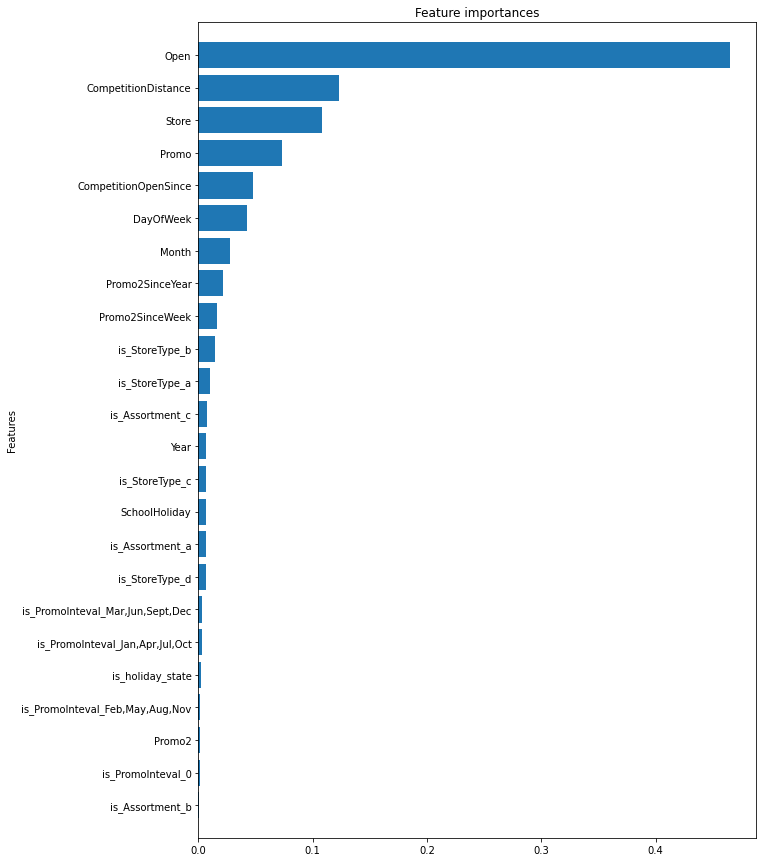

In [356]:
import itertools
importances = rf_model.feature_importances_
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette())

# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
    
# Plot the feature importances of the forest
plt.figure(figsize=(10,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()

# Conclusion

> The above graph is showing us that:
> - being open is having a major impact on sales (duh)
> - competition distance and promotion are having a major impact on sales - makes sense
> - store is having an impact on sales - hum maybe here there is something to deep dive in as this is not making much sense
> - Assortment type and store type are also relevant to estimate sales.

